# Trabalho de Inteligência Artificial


* Ariel Bor Cheng Chen
* Felipe Tadaki Tosta Ida
* Gusthavo Henrique Parra da Silva
* Juan Lucas Montanaro



A proposta do trabalho é implementarmos alguns algoritmos de busca em grafos.
Neste caso, dados os números de vértices e arestas, o grafo deve ser gerado aleatoriamente, estando cada vértice ligado com o seus "vizinhos" mais próximos (é um grafo-knn).

## Definições Iniciais

Então, em primeiro lugar, é preciso implementar um jeito de gerar o grafo-knn.

In [ ]:
#!pip install IPython  # -- eh preciso instalar a biblioteca no google.colab

In [1]:
# setup:
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
import time

from matplotlib.animation import FuncAnimation
from IPython import display
import sys
sys.setrecursionlimit(10001)

In [2]:
def gera_arestas(pontos:np.ndarray, qtd:int) -> list:
    """Gera uma lista de listas. Cada lista interna tem os indices dos 'qtd' 
    vertices mais proximos do ponto correspondente ao indice da lista externa.

    :pontos: vetor de vertices

    :qtd: numeros de conexoes de cada vertice
    
    :return: lista de listas
    """
    # vetor vazio, em que serao colocadas as listas
    arestas = [None for _ in range(pontos.shape[0])]

    # como 'arestas' e 'pontos' tem o mesmo tamanho, 
    # o valor de cada entrada eh o mesmo, assim:
    # 
    # pontos[i] - eh o i-esimo ponto (com suas coordenadas), e
    # arestas[i] - eh a lista com as arestas do i-esimo ponto

    # forma matricial de calcular a distancia entre todos os pontos
    x2 = np.array([(pontos[:,0]-x)**2 for x in pontos[:,0]])
    y2 = np.array([(pontos[:,1]-y)**2 for y in pontos[:,1]])

    dist_xy = (x2 + y2)**0.5
    # cada entrada (i,j) da matriz eh a dist entre os pontos i e j

    for i in range(len(arestas)):
        ind_mins = np.argsort(dist_xy[:,i])
        # lista com os indices das menores dist do ponto i
            
        arestas[i] = ind_mins[1:qtd+1]
        # ind_mins[0] eh a dist entre o ponto e ele mesmo, entao nao a pegue
    return arestas
    

def gera_grafo_knn(n:int, k:int):
    """Gera aleatoriamente um grafo com vertices no conjunto N^2, N:naturais.
    
    :n: quantidade de vertices do grafo e valor limite das coordenadas

    :k: quantidade de arestas

    :return: lista_de_vertices, listas_de_arestas
    """
    vertices = np.random.randint(1, n+1, (n,2)) #gera n vertices
    arestas = gera_arestas(vertices, k) #gera as arestas
    
    return vertices, arestas

In [4]:
# teste da funcao:
vert, art = gera_grafo_knn(2000, 7)
print('Shape de vert:', vert.shape)

Shape de vert: (2000, 2)


In [20]:
# so para facilitar escolher dois pontos e rodar todos os algoritmos com eles
V_ini = 1502
V_fim = 1987

In [ ]:
# Continuacao do teste da funcao:
plt.style.use('dark_background')
fig = plt.figure(figsize=(15,9), dpi=70) 

ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-5, vert.shape[0]+5), ax.set_xticks([])
ax.set_ylim(-5, vert.shape[0]+5), ax.set_yticks([])

scat = ax.scatter(vert[:,0], vert[:,1], zorder=2, s=9,
                  edgecolors='#0088cc', facecolors='black')
ax.scatter(vert[[V_ini, V_fim], 0], vert[[V_ini, V_fim], 1], s=15,
           edgecolors='#ff6600', facecolors='#ff6600', zorder=2)

text_size = 7

for i in range(vert.shape[0]):
    ax.annotate(i, xy=vert[i], fontsize=text_size, color='white')
    for j in art[i]:
        ax.plot(vert[[i,j], 0], vert[[i,j], 1], 
                color='#006699', alpha=0.6, zorder=1)

plt.title(f'{vert.shape[0]} Vértices com {len(art[0])} Arestas',
          fontsize = 20)

plt.show()

## Algoritmos de Busca

Agora nesta seção, é preciso implementar os algoritmos: deep-first, breadth-first, best-first, $A$, $A^*$ e Dijkstra.

Confira as implementações a seguir.

### Algoritmos & Funções auxiliares

In [8]:
def dist_euclid(p1:np.ndarray, p2:np.ndarray) -> float:
    """Calcula a distancia euclidiana entre dois pontos.
    
    :p1,p2: vetores da forma (x,y)
    
    :return: valor da distancia
    """
    aux = ((p1 - p2)**2).sum()**0.5
    return aux


def dist_manhat(p1:np.ndarray, p2:np.ndarray) -> float:
    """Calcula a distancia Manhattan (ou em módulo) entre dois pontos.
    
    :p1,p2: vetores da forma (x,y)
    
    :return: valor da distancia
    """
    aux = (abs(p1 - p2)).sum()
    return aux

In [9]:
def dfs(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray):
    """ Algoritmo recursivo de busca em profundidade: ele ira 'descer' no grafo,
    ate enquanto possivel, se nao, ele volta e tenta 'descer' por outros filhos.

    :Ini, Fim: indices que indicam as posicoes dos pontos de origem e destino

    :vertices: lista com todas as coordenadas dos vertices do grafo

    :arestas: lista com todas as conexoes entre os vertices

    :return: (chegou, caminho) 
           - chegou: indicacao se o algoritmo chegou ao ponto final (destino) ou nao
           - caminho: lista com os indices de todos os vertices por onde o algoritmo
                      passou, na forma [ (filho, pai), (neto, filho), ...]
    """
    if (Ini == Fim): # criterio de parada da recursao
        return True, deque()

    caminho = deque()
    chegou = False

    global visitados # lista do mesmo tamanho que 'vertives'; cada posicao
    visitados[Ini] = True # indica se o vertice ja foi visitado ou nao

    for i in arestas[Ini]:
        if (visitados[i]): # para evitar ciclos,
            continue # o vertice a ser visitado nao pode ja ter sido visitado
        
        visitados[i] = True # check para os vertices visitados
        caminho.append((i, Ini))   # criacao do caminho percorrido
        chegou, camR = dfs(i, Fim, vertices, arestas)
        caminho.extend(camR)# expandindo o caminho com o retorno da chamada recursiva
        if (chegou == True): break

    return chegou, caminho

In [10]:
def bfs(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray):
  """ Algoritmo iterativo de busca em largura: ele ira visitar todos os filhos
  do vertice em questao, depois visitara em ordem os filhos dos filhos.

    :Ini, Fim: indices que indicam as posicoes dos pontos de origem e destino

    :vertices: lista com todas as coordenadas dos vertices do grafo

    :arestas: lista com todas as conexoes entre os vertices

    :return: (chegou, caminho) 
           - chegou: indicacao se o algoritmo chegou ao ponto final ou nao
           - caminho: lista com os indices de todos os vertices por onde o algoritmo
                      passou, na forma [ (filho, pai), (neto, filho), ...]
  """
  opcoes = deque()  # funciona como uma fila; aqui serao armazenados os 
  opcoes.append((Ini, Ini)) # vertices filhos do atual vertice
  caminho = deque() # caminho que sera retornado
  chegou = False # constante so para manter o padrao das outras funcoes
  visitados = [False]*vertices.shape[0] # lista de vertices ja visitados

  while (len(opcoes) > 0): # enquanto houver opcoes disponiveis, faca
    filho_pai = opcoes.popleft()
    # retira o ponto, cujos filhos serao visitados, das opcoes disponiveis;
    # nesse caso, filho_pai = [no_a_ser_investigado, no_pai_dele]

    if (not visitados[filho_pai[0]]):
      caminho.append(filho_pai) # criando o caminho

      if (filho_pai[0] == Fim):
        chegou = True # condicao para forcar a parada da iteracao
        break
      else:
        visitados[filho_pai[0]] = True # check para visitado
        for neto in arestas[filho_pai[0]]:
          # adicionar os netos a lista de opcoes
          if (not visitados[neto]):
            opcoes.append((neto, filho_pai[0]))
            
  return chegou, caminho

In [11]:
def bestFirst(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray):
    """ Algoritmo recursivo de busca, o Best-First, em que os filhos sao 
    ordenados segundo a distancia euclidiana entre eles e o ponto final.

    :Ini, Fim: indices que indicam as posicoes na lista dos pontos de origem e destino

    :vertices: lista com todas as coordenadas dos vertices do grafo

    :arestas: lista com todas as conexoes entre os vertices

    :return: (chegou, caminho) 
           - chegou: indicacao se o algoritmo chegou ao ponto final (destino) ou nao
           - caminho: lista com os indices de todos os vertices por onde o algoritmo
                      passou, na forma [ (filho, pai), (neto, filho), ...]
    """
    if (Ini == Fim): # criterio de parada da recursao
        return True, deque()

    caminho = deque()
    chegou = False

    global visitados # lista do mesmo tamanho que 'vertives'; cada posicao
    visitados[Ini] = True # indica se o vertice ja foi visitado ou nao

    # ordenacao dos filhos pela distancia entre eles e 'Fim':
    dist_filho_fim = np.array([dist_euclid(vertices[f], vertices[Fim]) for f in arestas[Ini]])
    # indices dos filhos mais proximos de 'Fim'
    ind = arestas[Ini][np.argsort(dist_filho_fim)]
    #print(ind)
    del dist_filho_fim

    # loop para visitar todos os filhos
    for i in ind: 
        if (visitados[i]): # para evitar ciclos,
            continue # o vertice a ser visitado nao pode ja ter sido visitado
        else:
            visitados[i] = True # check para os vertices visitados
            caminho.append((i, Ini))   # criacao do caminho percorrido
            chegou, camR = bestFirst(i, Fim, vertices, arestas)
            caminho.extend(camR)# expandindo o caminho com o retorno da chamada recursiva
            if (chegou): break

    del ind
    return chegou, caminho

In [12]:
def insere_ordenado(fila:deque, no, indexOrd:list) -> deque:
    """ Funcao auxiliar para inserir 'no' em 'fila' de forma ordenada,
    com base no index 'indexOrd'.

    :fila: lista encadeada ordenada com os outros 'nos' 

    :no: tupla que sera inserida; da forma (vertice_principal, pai_dele)

    :indexOrd: lista com os valores que definem a ordem entre os vertices

    :return: a nova 'fila' atualizada.
    """
    if (no in fila): # se 'no' ja existe na fila, retire-o:
        fila.remove(no)

    inseriu = False
    i = 0
    while (i < len(fila)):
        # procure o indice do 1o item que tenha pesos maiores que o 'vertice_principal' 
        if (indexOrd[fila[i][0]] > indexOrd[no[0]]):
            fila.insert(i, no) # insera o 'no' antes do indice i
            inseriu = True
            break
        else: i += 1
    # caso o 'no' nao tenha sido inserido apos percorrer toda a lista, 
    if (not inseriu): fila.append(no) # insira-o no final

    return fila


def dijkstra(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray):
    """ Algoritmo iterativo de Dijkstra para encontrar o caminho com os menores
    pesos do vertice 'Ini' ao vertice 'Fim' (pesos = distancia euclidiana).

    :Ini, Fim: indices que indicam as posicoes na lista dos pontos de origem e destino

    :vertices: lista com todas as coordenadas dos vertices do grafo

    :arestas: lista com todas as conexoes entre os vertices

    :return: (chegou, caminho) 
           - chegou: indicacao se o algoritmo chegou ao ponto final (destino) ou nao
           - caminho: lista com os indices de todos os vertices por onde o algoritmo
                      passou, na forma [ (filho, pai), (neto, filho), ...]
    """
    n = vertices.shape[0]
    # criar uma lista de tam n, com valores iguais a 'infinito':
    dists = [n**2]*n # na vdd, n^2 eh suficiente para representar 'infinito'
    dists[Ini] = 0
    # dists eh um index que guardara os menores pesos de 'Ini' ate outro vertice

    opcoes = deque()  # funciona como uma fila; aqui serao armazenados os 
    opcoes.append((Ini, Ini)) # vertices filhos do atual vertice

    caminho = deque() # caminho que sera retornado
    chegou = False # constante so para manter o padrao das outras funcoes
    visitados = [False]*n # lista de vertices ja visitados

    while (len(opcoes) > 0): # enquanto houver opcoes disponiveis, faca
        filho_pai = opcoes.popleft()
        # retira o ponto, cujos filhos serao visitados, das opcoes disponiveis;
        # nesse caso, filho_pai = (no_a_ser_investigado, no_pai_dele)        

        if (not visitados[filho_pai[0]]):
            caminho.append(filho_pai) # criando o caminho

        if (filho_pai[0] == Fim): # se o no 'Fim' esta sendo investigado
            chegou = True  # entao, pode interromper o algoritmo; nenhum no que
            break          # vira dps tera um caminho com menos pesos ate 'Fim'

        visitados[filho_pai[0]] = True # marcacao para evitar ciclos

        # investigar os filhos do 'no_a_ser_investigado':
        for neto in arestas[filho_pai[0]]:
            if (visitados[neto]): 
                continue # nao precisa perder tempo com repeticoes

            # new_d eh o peso total do vertice 'Ini' ate o 'neto'
            new_d = dists[filho_pai[0]] 
            new_d += dist_euclid(vertices[filho_pai[0]], vertices[neto])

            # se ha um caminho com pesos menores de 'Ini' a 'neto',
            # atualize o index 'dists' 
            if (dists[neto] > new_d): dists[neto] = new_d

            # e, de qualquer forma, insira de forma ordenada, com base em
            # 'dists', o par (filho_do_no_investigado, no_investigado):
            opcoes = insere_ordenado(opcoes, (neto, filho_pai[0]), dists)
    
    # talvez precise arrumar o caminho
    return chegou, caminho

In [13]:
def A_star(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray):
    """ Algoritmo iterativo A* para encontrar o caminho com os menores pesos do
    vertice 'Ini' ao vertice 'Fim' (pesos = distancia euclidiana) combinados
    com a heuristica 'distancia euclidiana' ate 'Fim'.

    :Ini, Fim: indices que indicam as posicoes na lista dos pontos de origem e destino

    :vertices: lista com todas as coordenadas dos vertices do grafo

    :arestas: lista com todas as conexoes entre os vertices

    :return: (chegou, caminho) 
           - chegou: indicacao se o algoritmo chegou ao ponto final (destino) ou nao
           - caminho: lista com os indices de todos os vertices por onde o algoritmo
                      passou, na forma [ (filho, pai), (neto, filho), ...]
    """
    n = vertices.shape[0]
    # criar uma lista de tam n, com valores iguais a 'infinito':
    GpH = [n**2]*n # na vdd, n^2 eh suficiente para representar 'infinito'
    GpH[Ini] = 0
    # GpH eh um index que guardara os menores pesos de 'Ini' ate outros vertices
    # combinados com a distancia euclidiana ate o vertice 'Fim'

    opcoes = deque()  # funciona como uma fila; aqui serao armazenados os 
    opcoes.append((Ini, Ini)) # vertices filhos do atual vertice

    caminho = deque() # caminho que sera retornado
    chegou = False # constante so para manter o padrao das outras funcoes
    visitados = [False]*n # lista de vertices ja visitados

    while (len(opcoes) > 0): # enquanto houver opcoes disponiveis, faca
        filho_pai = opcoes.popleft()
        # retira o ponto, cujos filhos serao visitados, das opcoes disponiveis;
        # nesse caso, filho_pai = (no_a_ser_investigado, no_pai_dele)        

        if (not visitados[filho_pai[0]]):
            caminho.append(filho_pai) # criando o caminho

        if (filho_pai[0] == Fim): # se o no 'Fim' esta sendo investigado
            chegou = True  # entao, pode interromper o algoritmo; nenhum no que
            break          # vira dps tera um caminho com menos pesos ate 'Fim'

        visitados[filho_pai[0]] = True # marcacao para evitar ciclos

        # investigar os filhos do 'no_a_ser_investigado':
        for neto in arestas[filho_pai[0]]:
            if (visitados[neto]): 
                continue # nao precisa perder tempo com ciclos

            # new_d eh o peso total do vertice 'Ini' ate o 'neto'
            # mais a heuristica de 'neto' ate 'Fim'
            new_d = GpH[filho_pai[0]] 
            new_d += dist_euclid(vertices[filho_pai[0]], vertices[neto])
            new_d += dist_euclid(vertices[neto], vertices[Fim])

            # se ha um caminho com pesos menores de 'Ini' a 'neto',
            # atualize o index 'GpH' 
            if (GpH[neto] > new_d): GpH[neto] = new_d

            # e, de qualquer forma, insira de forma ordenada, com base em
            # 'GpH', o par (filho_do_no_investigado, no_investigado):
            opcoes = insere_ordenado(opcoes, (neto, filho_pai[0]), GpH)
    
    # talvez precise arrumar o caminho
    return chegou, caminho


def A_star_h100(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray):
    """ Idem a funcao 'A_star', porem com h*100. """
    n = vertices.shape[0]
    GpH = [n**2]*n
    GpH[Ini] = 0

    opcoes = deque()
    opcoes.append((Ini, Ini))
    caminho = deque()
    chegou = False
    visitados = [False]*n

    while (len(opcoes) > 0):
        filho_pai = opcoes.popleft()       

        if (not visitados[filho_pai[0]]):
            caminho.append(filho_pai)

        if (filho_pai[0] == Fim):
            chegou = True
            break

        visitados[filho_pai[0]] = True
        for neto in arestas[filho_pai[0]]:
            if (visitados[neto]): 
                continue

            new_d = GpH[filho_pai[0]] 
            new_d += dist_euclid(vertices[filho_pai[0]], vertices[neto])
            new_d += dist_euclid(vertices[neto], vertices[Fim])*100

            if (GpH[neto] > new_d): GpH[neto] = new_d
            opcoes = insere_ordenado(opcoes, (neto, filho_pai[0]), GpH)
    
    return chegou, caminho


def A_star_manh(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray):
    """ Idem a funcao 'A_star', porem com h sendo a distancia absoluta. """
    n = vertices.shape[0]
    GpH = [n**2]*n
    GpH[Ini] = 0

    opcoes = deque()
    opcoes.append((Ini, Ini))
    caminho = deque()
    chegou = False
    visitados = [False]*n

    while (len(opcoes) > 0):
        filho_pai = opcoes.popleft()       

        if (not visitados[filho_pai[0]]):
            caminho.append(filho_pai)

        if (filho_pai[0] == Fim):
            chegou = True
            break

        visitados[filho_pai[0]] = True
        for neto in arestas[filho_pai[0]]:
            if (visitados[neto]): 
                continue

            new_d = GpH[filho_pai[0]] 
            new_d += dist_euclid(vertices[filho_pai[0]], vertices[neto])
            new_d += dist_manhat(vertices[neto], vertices[Fim])

            if (GpH[neto] > new_d): GpH[neto] = new_d
            opcoes = insere_ordenado(opcoes, (neto, filho_pai[0]), GpH)
    
    return chegou, caminho

In [14]:
def arrumar_caminho(vertices:np.ndarray, caminho:deque):
    """ Funcao para selecionar apenas os vertices que conectam diretamente o primeiro
    e o ultimo itens da lista 'caminho', e já calcular a distancia entre eles.

    :vertices: lista com os valores x e y dos vertices do grafo

    :caminho: lista de indices

    :return: distancia:float, caminho_arrumado:deque. 
    """
    cam_arrumado = deque()
    cam_arrumado.append(caminho[-1])
    distancia = dist_euclid(vertices[ cam_arrumado[-1][0] ],
                            vertices[ cam_arrumado[-1][1] ])
    i = -2
    while (abs(i)-1 < len(caminho)):
        if (cam_arrumado[-1][1] == caminho[i][0]):
            distancia += dist_euclid(vertices[cam_arrumado[-1][0]],
                                     vertices[cam_arrumado[-1][1]])
            cam_arrumado.append(caminho[i])
        i -= 1
    return distancia, cam_arrumado


def print_formatado(Ini:int, Fim:int, vertices:np.ndarray,
                    arestas:np.ndarray, alg:str, printar:bool=True):
    """ Funcao para facilitar a analise dos algoritmos. Calcula a distancia percorrida
    pelo algoritmo entre os nos 'Ini' e 'Fim', o tempo demorado e printa as informacoes.

    :opcoes para alg: 'dfs', 'bfs', 'best', 'dtk', 'a*', 'a*h100' e 'a*manh'.

    :printar: booleano para indicar se a funcao deve mostrar o print formatado

    :return: para facilitar a vizualizacao, sera retornado 'tempo:float, distancia:float,
    cam:deque, cam_arrumado:deque'.
    """
    func = {'dfs': dfs, 'bfs': bfs, 'best': bestFirst,
            'dtk': dijkstra, 'a*': A_star,
            'a*h100': A_star_h100, 'a*manh': A_star_manh}

    try:
        global visitados
        visitados = [False]*vertices.shape[0]
        t_ini = time.time()
        chegou, cam = func[str(alg).lower()](Ini, Fim, vertices, arestas)
        delta_t = time.time() - t_ini

        distancia, cam_arrum = arrumar_caminho(vertices, cam)
    except Exception as e:
        print(e)
        return

    algs = {'dfs': 'Deep-First Search (Recursivo)',
            'a*': 'A*', 'bfs': 'Breadth-First Search',
            'best': 'Best-First Search', 'dtk': 'dijkstra',
            'a*h100': 'A* - 100h', 'a*manh': 'A* - Dist.Abs'
            }

    msg = f' -- Usando o algoritmo {algs[str(alg)]} -- '
    msg += f'\nEle chegou ao destino: {chegou}'
    msg += f'\nQts de vertices visitados: {len(cam)}'
    msg += f'\nTempo gasto: {delta_t:.6f} seg'
    msg += f'\nDistancia total: {distancia:.6f} u.d.'

    if (printar == True): print(msg)
    return delta_t, distancia, cam, cam_arrum


### Deep-First Search

In [15]:
t,d, cam, cam_a = print_formatado(V_ini, V_fim, vert, art, 'dfs')

 -- Usando o algoritmo Deep-First Search (Recursivo) -- 
Ele chegou ao destino: True
Qts de vertices visitados: 1729
Tempo gasto: 0.069957 seg
Distancia total: 20784.225413 u.d.


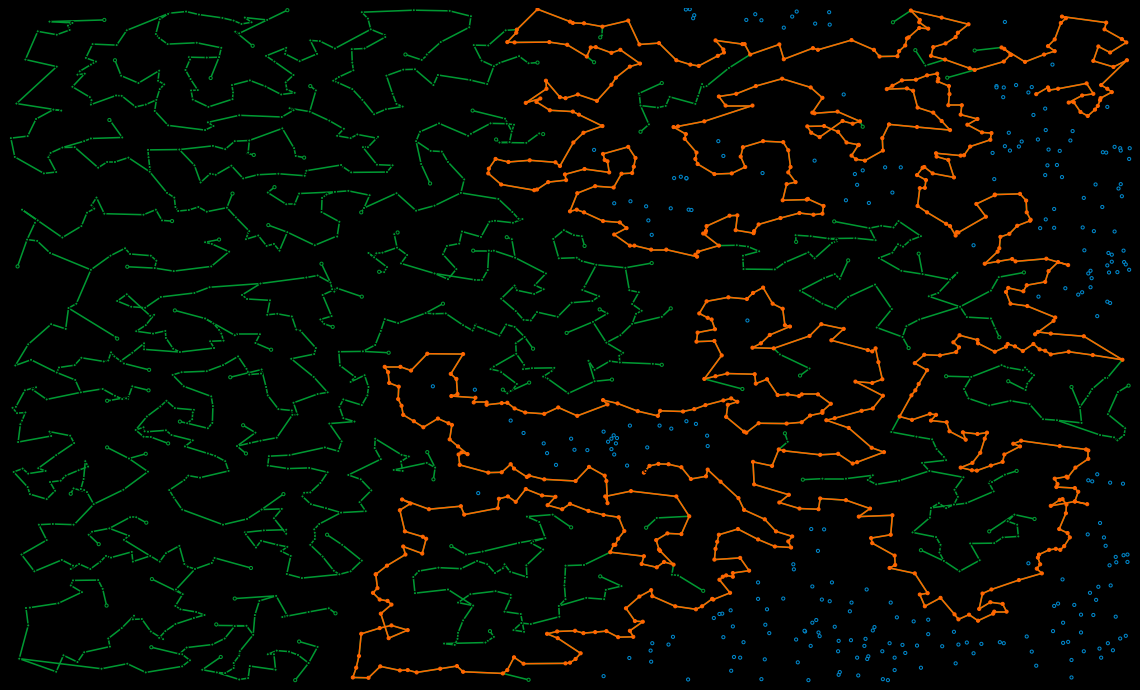

In [17]:
# Visualizacao da saida do algoritmo:
fig = plt.figure(figsize=(15,9), dpi=75) 

ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-5, vert.shape[0]+5), ax.set_xticks([])
ax.set_ylim(-5, vert.shape[0]+5), ax.set_yticks([])

edcol = ['#0088cc']*vert.shape[0]
edcol[V_ini] = 'black'
edcol[V_fim] = 'black'
fccol = ['black']*vert.shape[0]
fccol[V_ini] = '#009933'
fccol[V_fim] = '#ff6600'

scat = ax.scatter(vert[:,0], vert[:,1], zorder=2, s=9,
                  edgecolors=edcol, facecolors=fccol)

for i,j in cam:
    fccol[j] = '#009933'
    edcol[j] = 'black'
    edcol[i] = '#009933'
    ax.plot(vert[[j, i], 0], vert[[j, i], 1], 
            color='#009933', zorder=1)
    
for i, j in cam_a:
    fccol[j] = '#ff6600'
    edcol[j] = 'black'
    edcol[i] = '#ff6600'
    ax.plot(vert[[j, i], 0], vert[[j, i], 1],
            color='#ff6600', zorder=1)

scat.set_facecolors(fccol)
scat.set_edgecolors(edcol)
plt.show()

### Breadth-First Search

In [20]:
t,d, camBfs, camBfs_a = print_formatado(V_ini, V_fim, vert, art, 'bfs')

 -- Usando o algoritmo Breadth-First Search -- 
Ele chegou ao destino: True
Qts de vertices visitados: 1617
Tempo gasto: 0.020985 seg
Distancia total: 1478.434878 u.d.


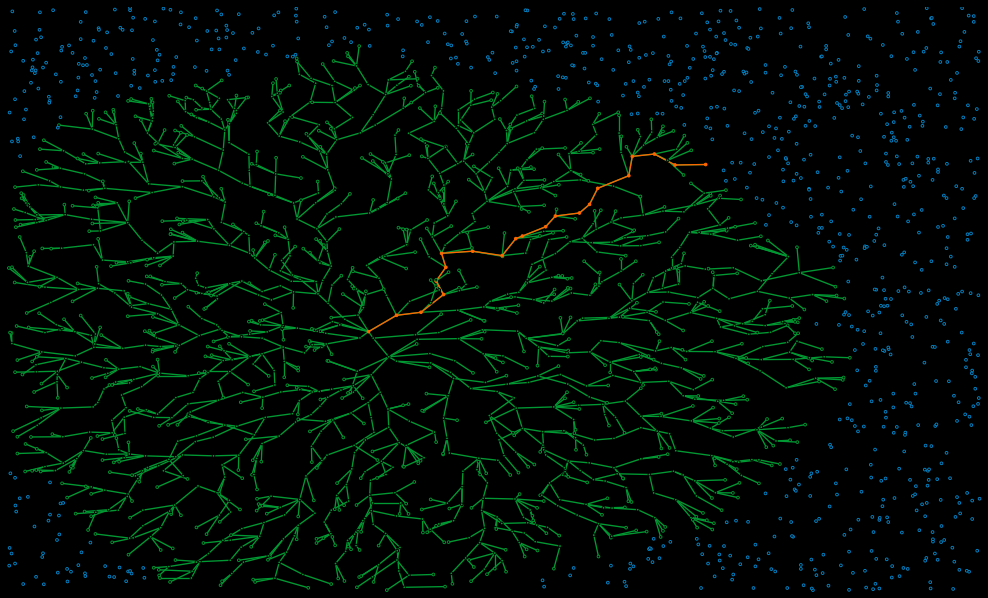

In [21]:
# Visualizacao da saida do algoritmo:
fig = plt.figure(figsize=(15,9), dpi=65) 

ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-5, vert.shape[0]+5), ax.set_xticks([])
ax.set_ylim(-5, vert.shape[0]+5), ax.set_yticks([])

edcol = ['#0088cc']*vert.shape[0]
edcol[V_ini] = 'black'
edcol[V_fim] = 'black'
fccol = ['black']*vert.shape[0]
fccol[V_ini] = '#009933'
fccol[V_fim] = '#ff6600'

scat = ax.scatter(vert[:,0], vert[:,1], zorder=2, s=9,
                  edgecolors='#0088cc', facecolors=fccol)

for i,j in camBfs:
    fccol[j] = '#009933'
    edcol[j] = 'black'
    edcol[i] = '#009933'
    ax.plot(vert[[i, j], 0], vert[[i, j], 1], color='#009933', zorder=1)

for i, j in camBfs_a:
    fccol[j] = '#ff6600'
    edcol[j] = 'black'
    edcol[i] = '#ff6600'
    ax.plot(vert[[j, i], 0], vert[[j, i], 1],
            color='#ff6600', zorder=1)

fccol[V_fim] = '#ff6600'
scat.set_facecolors(fccol)
scat.set_edgecolors(edcol)
plt.show()

### Best-First

In [22]:
t,d, camBF, camBF_a = print_formatado(V_ini, V_fim, vert, art, 'best')

 -- Usando o algoritmo Best-First Search -- 
Ele chegou ao destino: True
Qts de vertices visitados: 20
Tempo gasto: 0.006997 seg
Distancia total: 1022.973015 u.d.


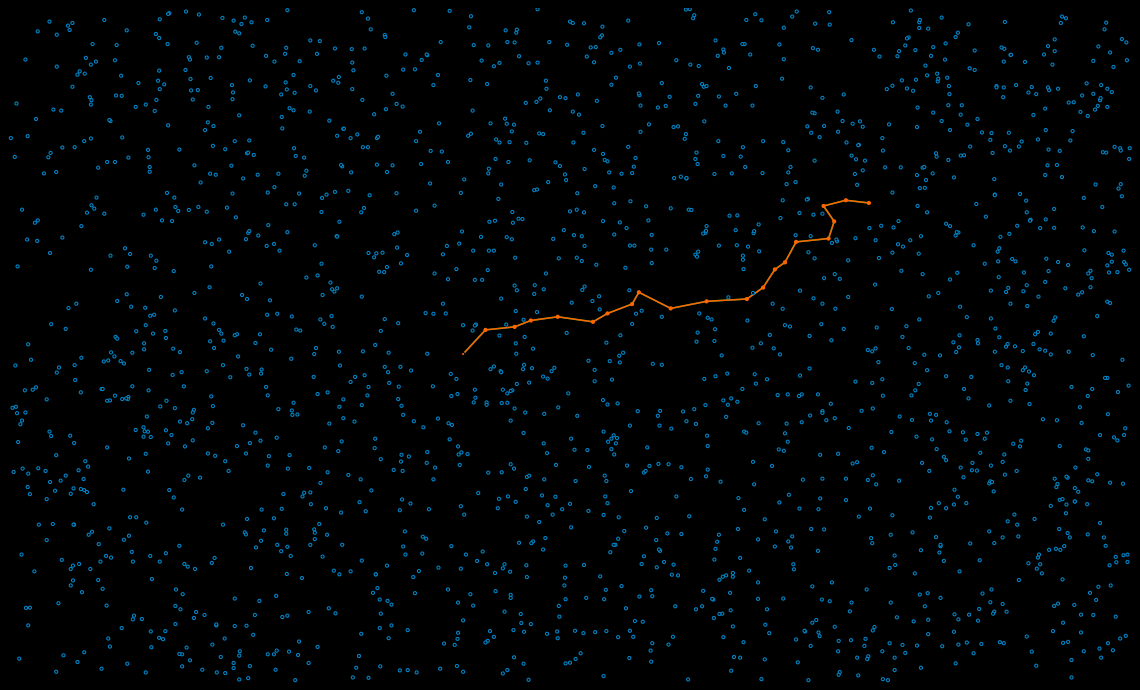

In [23]:
# Visualizacao da saida do algoritmo:
fig = plt.figure(figsize=(15,9), dpi=75) 

ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-5, vert.shape[0]+5), ax.set_xticks([])
ax.set_ylim(-5, vert.shape[0]+5), ax.set_yticks([])

edcol = ['#0088cc']*vert.shape[0]
edcol[V_ini] = 'black'
edcol[V_fim] = 'black'
fccol = ['black']*vert.shape[0]
fccol[V_ini] = '#009933'
fccol[V_fim] = '#ff6600'

scat = ax.scatter(vert[:,0], vert[:,1], zorder=2, s=9,
                  edgecolors=edcol, facecolors=fccol)

for i,j in camBF:
    fccol[j] = '#009933'
    edcol[j] = 'black'
    edcol[i] = '#009933'
    ax.plot(vert[[j, i], 0],
            vert[[j, i], 1],
            color='#009933', zorder=1)
    
for i, j in camBF_a:
    fccol[j] = '#ff6600'
    edcol[j] = 'black'
    edcol[i] = '#ff6600'
    ax.plot(vert[[j, i], 0], vert[[j, i], 1],
            color='#ff6600', zorder=1)
    
scat.set_facecolors(fccol)
scat.set_edgecolors(edcol)
plt.show()

### Dijkstra

In [24]:
t,d, camDtk, camDtk_a = print_formatado(V_ini, V_fim, vert, art, 'dtk')

 -- Usando o algoritmo dijkstra -- 
Ele chegou ao destino: True
Qts de vertices visitados: 1581
Tempo gasto: 1.823872 seg
Distancia total: 1362.745623 u.d.


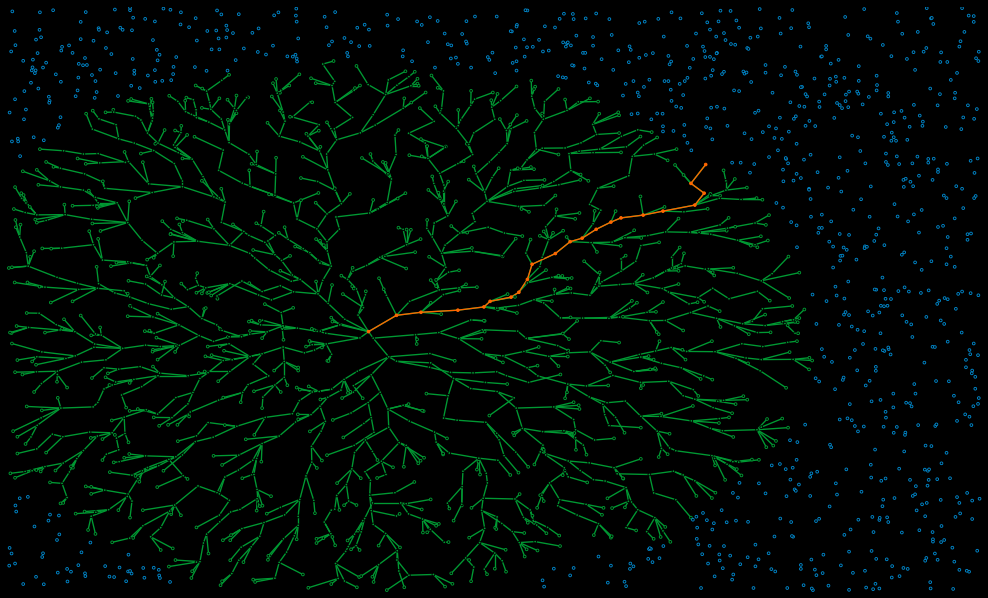

In [25]:
# Visualizacao da saida do algoritmo:
fig = plt.figure(figsize=(15,9), dpi=65) 

ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-5, vert.shape[0]+5), ax.set_xticks([])
ax.set_ylim(-5, vert.shape[0]+5), ax.set_yticks([])

edcol = ['#0088cc']*vert.shape[0]
edcol[V_ini] = 'black'
edcol[V_fim] = 'black'
fccol = ['black']*vert.shape[0]
fccol[V_ini] = '#009933'
fccol[V_fim] = '#ff6600'

scat = ax.scatter(vert[:,0], vert[:,1], zorder=2, s=9,
                  edgecolors='#0088cc', facecolors=fccol)

for i,j in camDtk:
    fccol[j] = '#009933'
    edcol[j] = 'black'
    edcol[i] = '#009933'
    ax.plot(vert[[i, j], 0], vert[[i, j], 1], color='#009933', zorder=1)

for i, j in camDtk_a:
    fccol[j] = '#ff6600'
    edcol[j] = 'black'
    edcol[i] = '#ff6600'
    ax.plot(vert[[j, i], 0], vert[[j, i], 1], color='#ff6600', zorder=1)

fccol[V_fim] = '#ff6600'
scat.set_facecolors(fccol)
scat.set_edgecolors(edcol)
plt.show()

### Alg $A^*$

In [26]:
t,d, camAs, camAs_a = print_formatado(V_ini, V_fim, vert, art, 'a*')

 -- Usando o algoritmo A* -- 
Ele chegou ao destino: True
Qts de vertices visitados: 530
Tempo gasto: 0.509683 seg
Distancia total: 1469.511315 u.d.


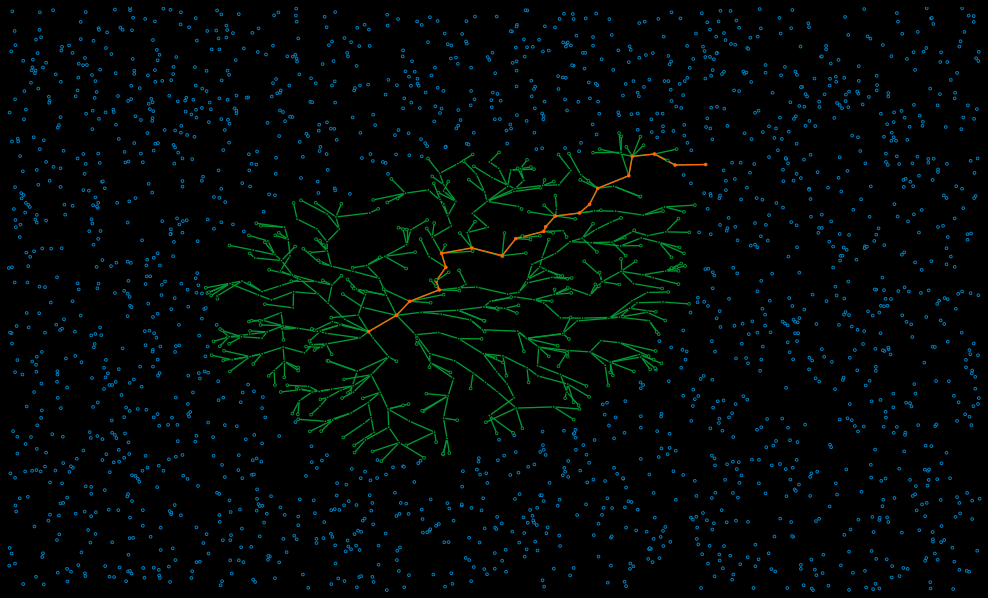

In [27]:
# Visualizacao da saida do algoritmo:
fig = plt.figure(figsize=(15,9), dpi=65) 

ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-5, vert.shape[0]+5), ax.set_xticks([])
ax.set_ylim(-5, vert.shape[0]+5), ax.set_yticks([])

edcol = ['#0088cc']*vert.shape[0]
edcol[V_ini] = 'black'
edcol[V_fim] = 'black'
fccol = ['black']*vert.shape[0]
fccol[V_ini] = '#009933'
fccol[V_fim] = '#ff6600'

scat = ax.scatter(vert[:,0], vert[:,1], zorder=2, s=9,
                  edgecolors='#0088cc', facecolors=fccol)

for i,j in camAs:
    fccol[j] = '#009933'
    edcol[j] = 'black'
    edcol[i] = '#009933'
    ax.plot(vert[[i, j], 0], vert[[i, j], 1], color='#009933', zorder=1)

for i, j in camAs_a:
    fccol[j] = '#ff6600'
    edcol[j] = 'black'
    edcol[i] = '#ff6600'
    ax.plot(vert[[j, i], 0], vert[[j, i], 1], color='#ff6600', zorder=1)

fccol[V_fim] = '#ff6600'
scat.set_facecolors(fccol)
scat.set_edgecolors(edcol)
plt.show()

## Visualização dos Algoritmos

Por fim, nesta seção, criaremos pequenas funções usando o _matplotlib_ para visualizar como os algoritmos de busca funcionam.

### Definições das funções

In [25]:
def viz(Ini:int, Fim:int, vertices:np.ndarray, arestas:np.ndarray, alg:str):
    """ Funcao para gerar um video do algoritmo percorrendo o grafo.
    """
    _,_, cam, cam_arrum = print_formatado(Ini, Fim, vertices, arestas, alg)

    fig = plt.figure(figsize=(15,9), dpi=65) 
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.set_xlim(-5, vertices.shape[0]+5), ax.set_xticks([])
    ax.set_ylim(-5, vertices.shape[0]+5), ax.set_yticks([])

    edcol = ['#0088cc']*vertices.shape[0]
    edcol[Ini] = 'black'
    edcol[Fim] = 'black'
    fccol = ['black']*vertices.shape[0]
    fccol[Ini] = '#009933'
    fccol[Fim] = '#ff6600'

    scat = ax.scatter(vertices[:,0], vertices[:,1], zorder=2,
                      edgecolors=edcol, facecolors=fccol, s=9)

    # funcao de animacao: 
    def animate(i):
        n = len(cam)
        if (i < n):
            fccol[cam[i][1]] = '#009933'
            edcol[cam[i][1]] = 'black'
            edcol[cam[i][0]] = '#009933'
            ax.plot(vertices[[cam[i][1], cam[i][0]], 0],
                    vertices[[cam[i][1], cam[i][0]], 1],
                    color='#009933', zorder=1)
            scat.set_edgecolors(edcol)
            scat.set_facecolors(fccol)
        elif (i < n+len(cam_arrum)):
            fccol[cam_arrum[i-n][1]] = '#ff6600'
            edcol[cam_arrum[i-n][1]] = 'black'
            edcol[cam_arrum[i-n][0]] = '#ff6600'
            ax.plot(vertices[[cam_arrum[i-n][1], cam_arrum[i-n][0]], 0],
                    vertices[[cam_arrum[i-n][1], cam_arrum[i-n][0]], 1],
                    color='#ff6600', zorder=1)
            scat.set_edgecolors(edcol)
            scat.set_facecolors(fccol)

    anim = FuncAnimation(fig, animate, frames=len(cam)+len(cam_arrum)+15,
                         interval=50, blit=False)
    plt.close()
    return anim

### Videos

In [ ]:
anim = viz(V_ini, V_fim, vert, art, 'dfs')
#anim.save('dfs.mp4')

# Execute no Colab
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)

In [ ]:
anim = viz(V_ini, V_fim, vert, art, 'bfs')
#anim.save('bfs.mp4')

# Execute no Colab
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)

In [ ]:
anim = viz(V_ini, V_fim, vert, art, 'best')
anim.save('best.mp4', writer=animation.writers['html'](dpi=65))

# Execute no Colab
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)

In [ ]:
anim = viz(V_ini, V_fim, vert, art, 'dtk')
#anim.save('dtk.mp4')

# Execute no Colab
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)

In [ ]:
anim = viz(V_ini, V_fim, vert, art, 'a*')
#anim.save('a_star.mp4')

# Execute no Colab
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)